[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CompOmics/D012554A_2025/blob/main/notebooks/day_3/answers/3.1b_Exercises_Histone_marks_dt_answers.ipynb)

# 3.1 Exercises – Decision Trees, Bias-Variance & Ensemble Learning (Answers)

In the lecture notebook you applied decision trees, bagging, and random forests to classify gene expression from histone modifications. In these exercises you will apply those same techniques to the Breast Cancer Wisconsin dataset you already know from the logistic regression exercises — so you can directly compare decision-tree–based models with logistic regression.

## What you will learn

| Part | Topic |
| --- | --- |
| Exercises 1–4 | Fit & tune a single decision tree |
| Exercises 5–7 | Understand bias & variance by training many trees and tracking individual predictions |
| Exercises 8–9 | See how ensemble learning (bagging, random forest) reduces variance |
| Bonus | Compare all approaches in a summary table |

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

random_seed = 42
np.random.seed(random_seed)

---
## Exercise 1 – Load the data and create a train/validation split

1. Load the Breast Cancer dataset with `load_breast_cancer()`.
2. Create a DataFrame for features and a Series for the target.
3. Split into 80 % training / 20 % validation (`random_state=42`).
4. Print the shape of both sets and the class distribution of the training set.

In [2]:
data = load_breast_cancer()
features = pd.DataFrame(data.data, columns=data.feature_names)
target = pd.Series(data.target, name='target')

train_X, val_X, train_y, val_y = train_test_split(
    features, target, test_size=0.2, random_state=random_seed
)

print(f"Training set:   {train_X.shape}")
print(f"Validation set: {val_X.shape}")
print(f"\nClass distribution (train) — 0=malignant, 1=benign:")
print(train_y.value_counts())

Training set:   (455, 30)
Validation set: (114, 30)

Class distribution (train) — 0=malignant, 1=benign:
target
1    286
0    169
Name: count, dtype: int64


---
## Exercise 2 – Fit a decision tree with limited depth

1. Create a `DecisionTreeClassifier` with `max_depth=3` and `random_state=42`.
2. Fit it on the training data.
3. Compute and print the accuracy and log-loss on both the training and validation sets.

In [3]:
cls = DecisionTreeClassifier(max_depth=3, random_state=random_seed)
cls.fit(train_X, train_y)

pred_train = cls.predict(train_X)
pred_val   = cls.predict(val_X)
prob_train = cls.predict_proba(train_X)
prob_val   = cls.predict_proba(val_X)

print(f"Accuracy:  (train) {accuracy_score(train_y, pred_train):.4f}  "
      f"(val) {accuracy_score(val_y, pred_val):.4f}")
print(f"Log-loss:  (train) {log_loss(train_y, prob_train):.4f}  "
      f"(val) {log_loss(val_y, prob_val):.4f}")

Accuracy:  (train) 0.9780  (val) 0.9474
Log-loss:  (train) 0.0754  (val) 0.7604


---
## Exercise 3 – Visualize the decision tree

Use `sklearn.tree.plot_tree` to visualize the tree you just trained.

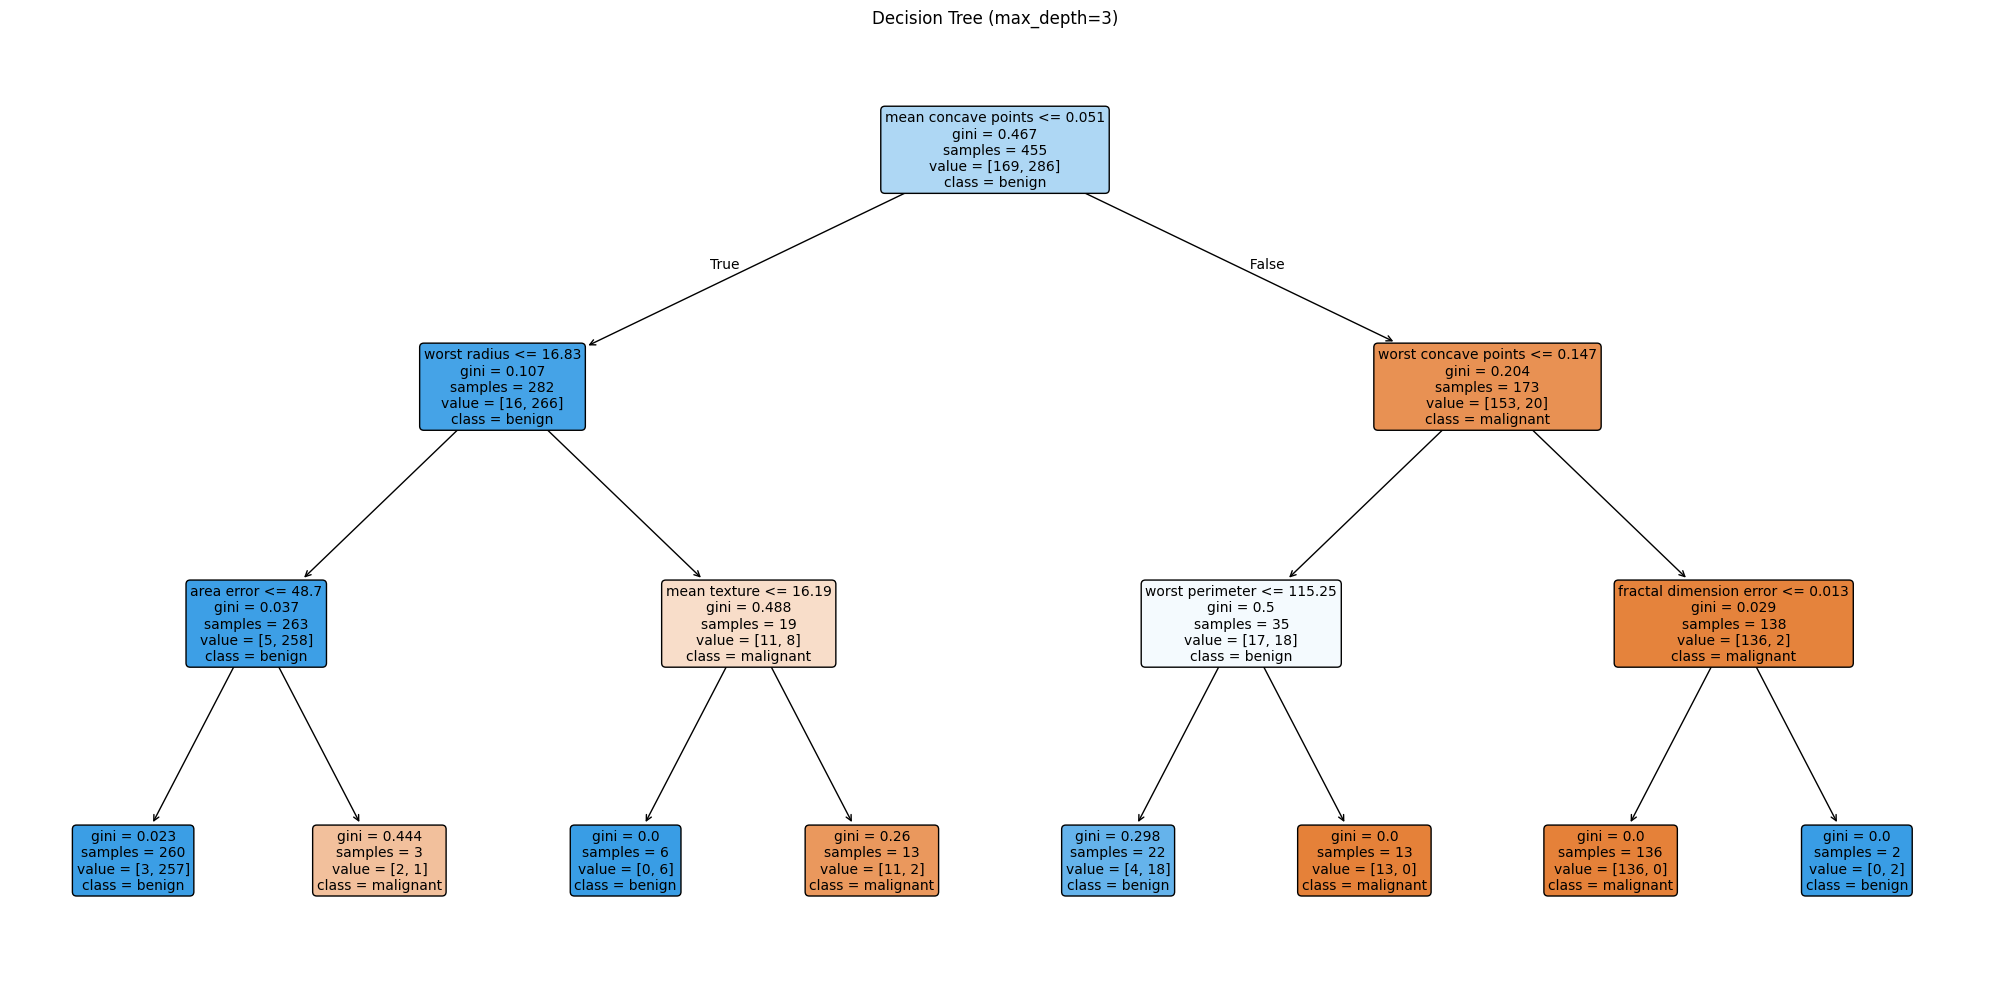

In [4]:
plt.figure(figsize=(20, 10))
plot_tree(cls, feature_names=data.feature_names,
          class_names=data.target_names,
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree (max_depth=3)')
plt.tight_layout()
plt.show()

---
## Exercise 4 – Effect of `max_depth` (overfitting curve)

1. Use `GridSearchCV` with `max_depth` values from 1 to 15 and `scoring='neg_log_loss'`.
2. Use 5-fold CV and set `return_train_score=True`.
3. Plot the mean training log-loss and mean validation log-loss vs `max_depth`.
4. Print the best `max_depth`.

Fitting 5 folds for each of 15 candidates, totalling 75 fits


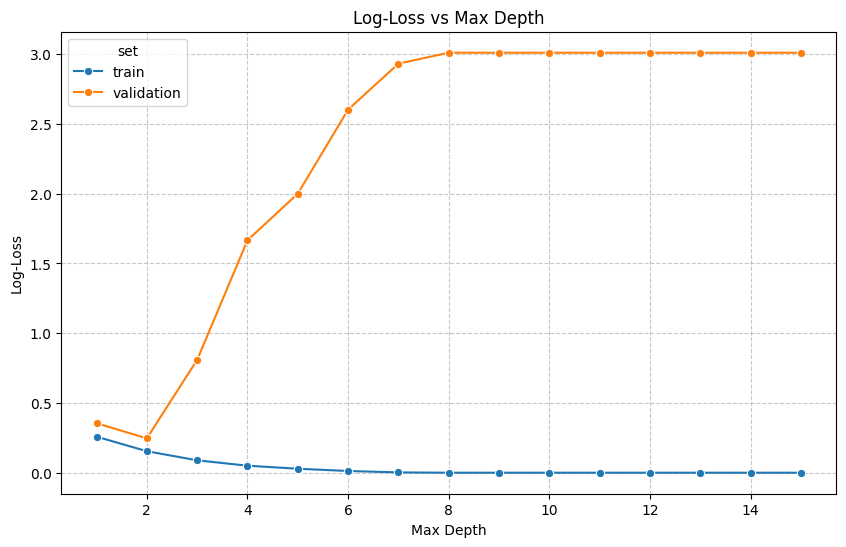

Best max_depth: 2


In [5]:
param_grid = {'max_depth': range(1, 16)}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=random_seed),
    param_grid,
    scoring='neg_log_loss',
    cv=5,
    return_train_score=True,
    verbose=1
)
grid_search.fit(train_X, train_y)

results = pd.DataFrame(grid_search.cv_results_)
plot_data = pd.DataFrame({
    'max_depth': results['param_max_depth'].astype(int),
    'train': -results['mean_train_score'],
    'validation': -results['mean_test_score']
})
plot_melted = plot_data.melt(id_vars='max_depth', var_name='set', value_name='log-loss')

plt.figure(figsize=(10, 6))
sns.lineplot(x='max_depth', y='log-loss', hue='set', data=plot_melted, marker='o')
plt.title('Log-Loss vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Log-Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

best_depth = grid_search.best_params_['max_depth']
print(f"Best max_depth: {best_depth}")

The training log-loss keeps decreasing as the tree gets deeper (eventually reaching 0), while the validation log-loss starts to increase after a certain point. This is the overfitting point: the tree memorises the training data but fails to generalise.

---
# Part 2 – Understanding Bias & Variance

In machine learning, prediction errors come from two main sources:

Bias is the error from wrong assumptions. A model with high bias oversimplifies and misses patterns in the data. *Example*: a decision tree with `max_depth=1` can only make a single split — it cannot capture complex relationships.

Variance is the error from sensitivity to which data we happen to train on. A model with high variance changes drastically when trained on different subsets. *Example*: a deep decision tree memorises the training data, so different training sets produce wildly different models.

| | Low Variance | High Variance |
|---|---|---|
| Low Bias | ✅ Ideal model | ⚠️ Overfitting |
| High Bias | ⚠️ Underfitting | ❌ Both problems |

Key insight: Ensemble methods (bagging, random forests) reduce variance by averaging many high-variance models, giving us the best of both worlds: low bias and low variance.

In the next exercises you will see this in action!

---
## Exercise 5 – Variance in action: 50 trees, 50 stories

Train 50 unrestricted decision trees on bootstrap samples and analyse prediction variance.

Average prediction variance: 0.0373
Log-loss (averaged predictions): 0.1072
Log-loss (single tree #0):       2.2132


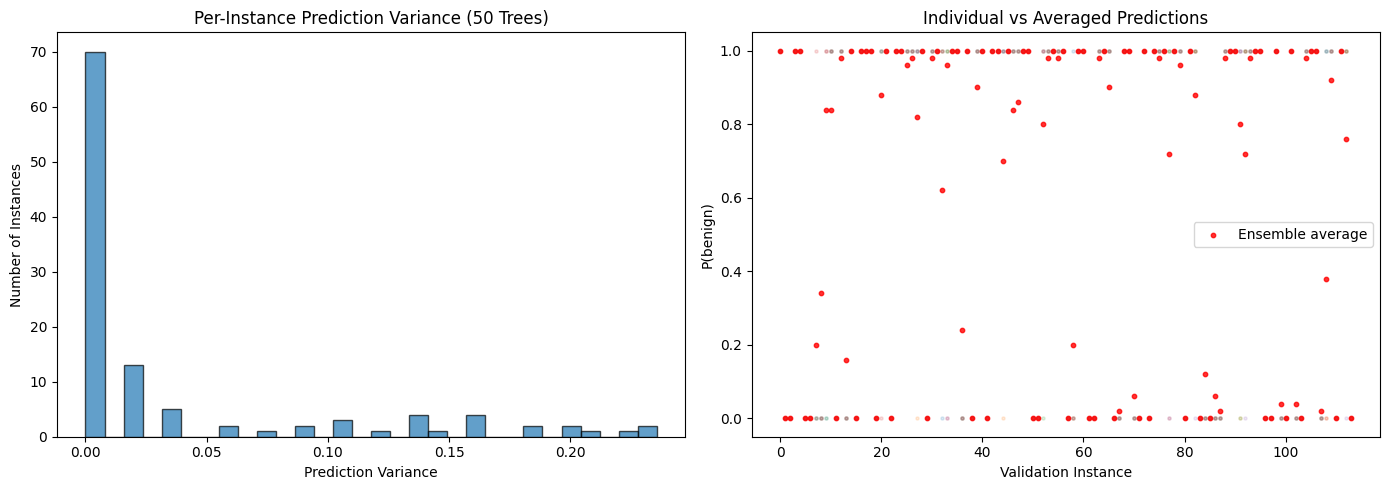

In [6]:
n_models = 50
all_probs = np.zeros((n_models, len(val_X)))

for i in range(n_models):
    rng = np.random.RandomState(i)
    boot_idx = rng.choice(len(train_X), size=len(train_X), replace=True)
    boot_X = train_X.iloc[boot_idx]
    boot_y = train_y.iloc[boot_idx]

    dt = DecisionTreeClassifier(random_state=i)
    dt.fit(boot_X, boot_y)
    all_probs[i] = dt.predict_proba(val_X)[:, 1]

# Analyse
variance_per_instance = all_probs.var(axis=0)
mean_pred = all_probs.mean(axis=0)

print(f"Average prediction variance: {variance_per_instance.mean():.4f}")
print(f"Log-loss (averaged predictions): {log_loss(val_y, mean_pred):.4f}")
print(f"Log-loss (single tree #0):       {log_loss(val_y, all_probs[0]):.4f}")

# Visualise
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(variance_per_instance, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Prediction Variance')
axes[0].set_ylabel('Number of Instances')
axes[0].set_title('Per-Instance Prediction Variance (50 Trees)')

for j in range(min(5, n_models)):
    axes[1].scatter(range(len(val_y)), all_probs[j], alpha=0.15, s=5)
axes[1].scatter(range(len(val_y)), mean_pred, color='red', s=10,
                alpha=0.8, label='Ensemble average', zorder=5)
axes[1].set_xlabel('Validation Instance')
axes[1].set_ylabel('P(benign)')
axes[1].set_title('Individual vs Averaged Predictions')
axes[1].legend()

plt.tight_layout()
plt.show()

Notice how the ensemble average (red dots) is much more stable and closer to 0 or 1 than the individual trees. The individual trees show huge scatter, especially for instances that are hard to classify. Averaging these noisy but unbiased predictions dramatically reduces the variance and improves log-loss.

---
## Exercise 6 – Following individual instances

Pick three specific validation instances and create histograms of their predicted probabilities across all 50 trees.

Easy   (idx=0): true=1, variance=0.0000
Hard   (idx=32): true=1, variance=0.2356
Medium (idx=3): true=1, variance=0.0000


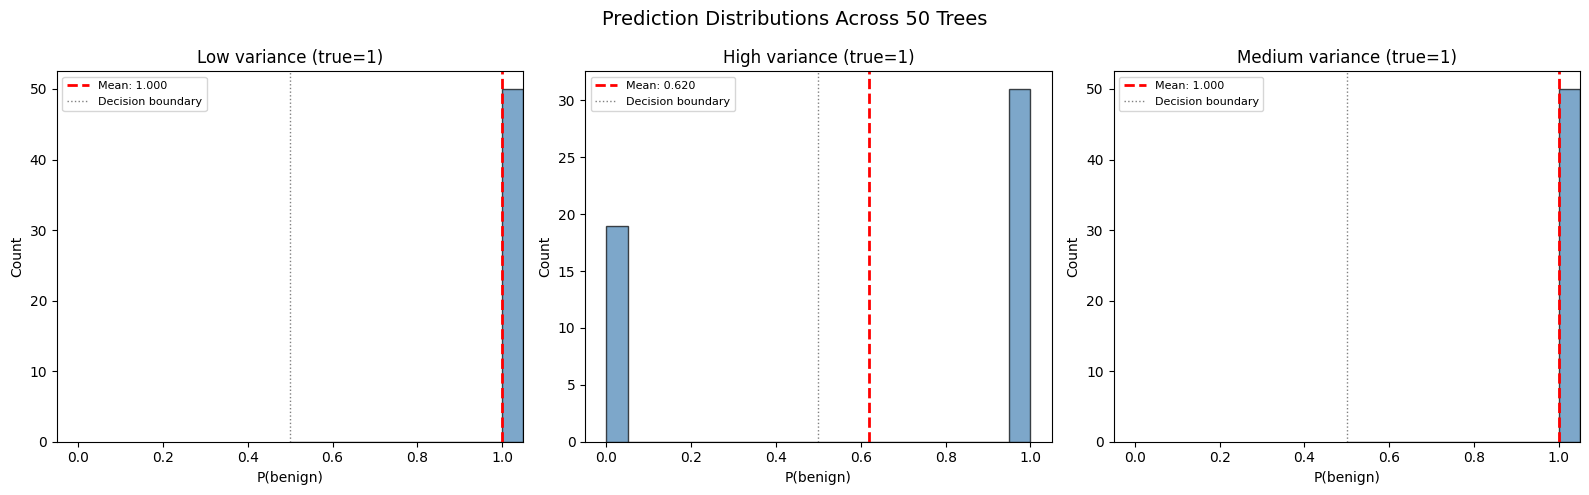

In [7]:
instance_variances = all_probs.var(axis=0)
easy_idx   = np.argmin(instance_variances)
hard_idx   = np.argmax(instance_variances)
medium_idx = np.argsort(instance_variances)[len(instance_variances) // 2]

print(f"Easy   (idx={easy_idx}): true={val_y.iloc[easy_idx]}, variance={instance_variances[easy_idx]:.4f}")
print(f"Hard   (idx={hard_idx}): true={val_y.iloc[hard_idx]}, variance={instance_variances[hard_idx]:.4f}")
print(f"Medium (idx={medium_idx}): true={val_y.iloc[medium_idx]}, variance={instance_variances[medium_idx]:.4f}")

tracked = {
    f"Low variance (true={val_y.iloc[easy_idx]})": all_probs[:, easy_idx],
    f"High variance (true={val_y.iloc[hard_idx]})": all_probs[:, hard_idx],
    f"Medium variance (true={val_y.iloc[medium_idx]})": all_probs[:, medium_idx]
}

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for ax, (label, preds) in zip(axes, tracked.items()):
    ax.hist(preds, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(preds.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {preds.mean():.3f}')
    ax.axvline(0.5, color='gray', linestyle=':', linewidth=1,
               label='Decision boundary')
    ax.set_xlabel('P(benign)')
    ax.set_ylabel('Count')
    ax.set_title(label)
    ax.legend(fontsize=8)
    ax.set_xlim(-0.05, 1.05)

plt.suptitle('Prediction Distributions Across 50 Trees', fontsize=14)
plt.tight_layout()
plt.show()

Interpretation:

- Low variance instance: All 50 trees agree — the histogram is tightly concentrated around 0 or 1. This is an "easy" sample that all trees classify consistently.
- High variance instance: The predictions are spread widely across [0, 1]. Different bootstrap samples lead to completely different predictions. This is where bias-variance matters most.
- Medium variance instance: Moderate spread. Most trees agree, but some disagree.

For the high-variance instance, a single tree could give any prediction depending on the training data. Averaging 50 trees gives a much more reliable estimate.

---
## Exercise 7 – The power of averaging: growing ensembles

Show how ensemble size affects both log-loss and individual predictions.

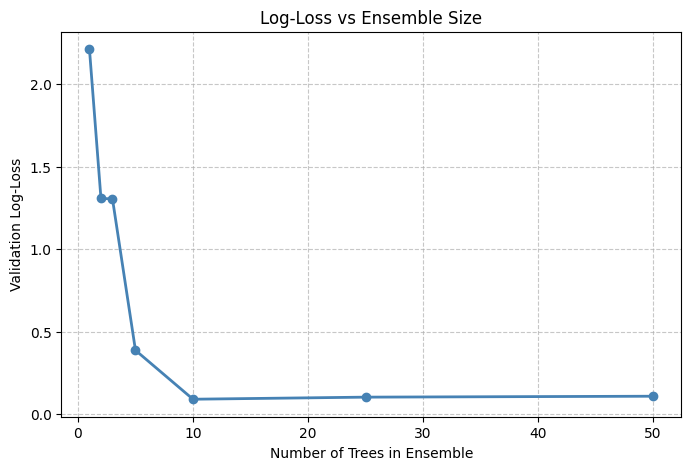

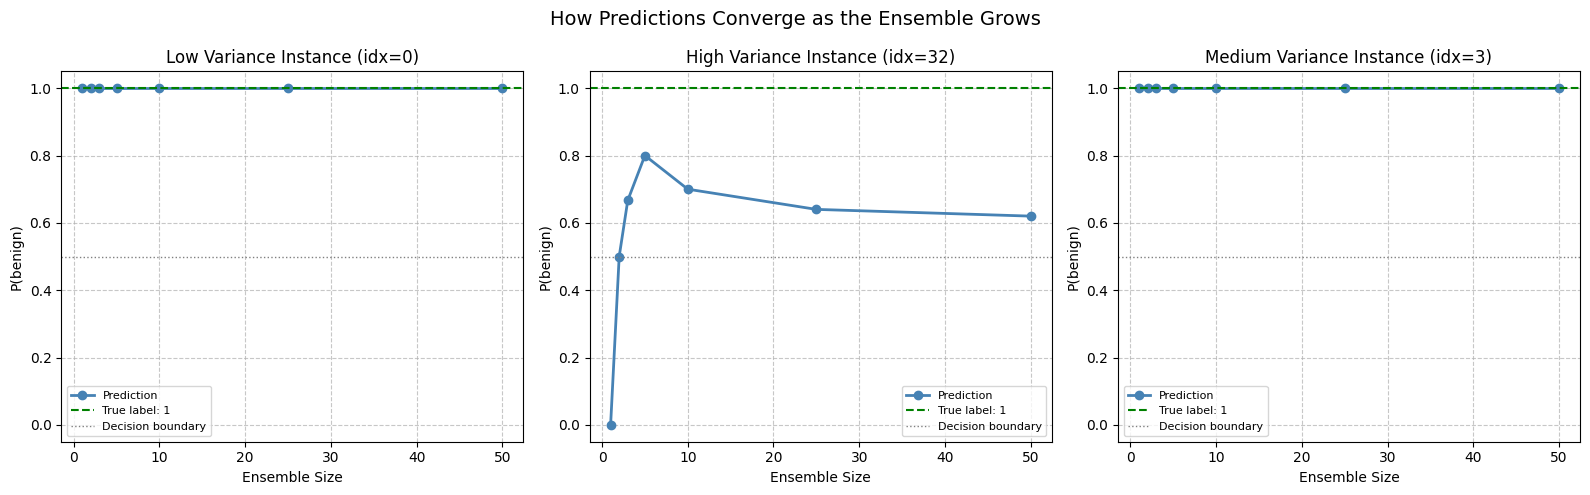

In [8]:
ensemble_sizes = [1, 2, 3, 5, 10, 25, 50]

log_losses_by_size = []
tracked_idx = [easy_idx, hard_idx, medium_idx]
tracked_preds = {idx: [] for idx in tracked_idx}

for size in ensemble_sizes:
    avg_probs = all_probs[:size].mean(axis=0)
    ll = log_loss(val_y, avg_probs)
    log_losses_by_size.append(ll)
    for idx in tracked_idx:
        tracked_preds[idx].append(avg_probs[idx])

# --- Figure 1: Log-loss vs ensemble size ---
plt.figure(figsize=(8, 5))
plt.plot(ensemble_sizes, log_losses_by_size, 'o-', color='steelblue', linewidth=2)
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Validation Log-Loss')
plt.title('Log-Loss vs Ensemble Size')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# --- Figure 2: Tracked instances as ensemble grows ---
labels = ['Low Variance', 'High Variance', 'Medium Variance']
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, idx, label in zip(axes, tracked_idx, labels):
    true_label = val_y.iloc[idx]
    ax.plot(ensemble_sizes, tracked_preds[idx], 'o-',
            color='steelblue', linewidth=2, label='Prediction')
    ax.axhline(true_label, color='green', linestyle='--',
               linewidth=1.5, label=f'True label: {true_label}')
    ax.axhline(0.5, color='gray', linestyle=':', linewidth=1,
               label='Decision boundary')
    ax.set_xlabel('Ensemble Size')
    ax.set_ylabel('P(benign)')
    ax.set_title(f'{label} Instance (idx={idx})')
    ax.set_ylim(-0.05, 1.05)
    ax.legend(fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.7)

plt.suptitle('How Predictions Converge as the Ensemble Grows', fontsize=14)
plt.tight_layout()
plt.show()

Key observations:

1. Log-loss drops rapidly as we go from 1 to ~10 trees, then levels off. Even 5 trees is much better than 1!
2. Low-variance instance: The prediction is stable from the very first tree — the ensemble doesn't change it much.
3. High-variance instance: With just 1–2 trees, the prediction jumps around wildly. As the ensemble grows, it converges toward a stable value.
4. Medium-variance instance: Shows intermediate behaviour — stabilises after ~5–10 trees.

This demonstrates the fundamental mechanism behind ensemble methods: averaging reduces variance.

---
# Part 3 – Ensemble Learning with scikit-learn

- `BaggingClassifier`: trains each tree on a different bootstrap sample.
- `RandomForestClassifier`: like bagging, but also randomly selects a *subset of features* at each split, further decorrelating the trees.

---
## Exercise 8 – BaggingClassifier: effect of ensemble size

Fit `BaggingClassifier` for several values of `n_estimators` and plot the results.

 n_estimators  accuracy  log_loss
            1  0.964912  1.264690
            5  0.956140  0.103040
           10  0.956140  0.121409
           25  0.956140  0.115625
           50  0.956140  0.110352
          100  0.956140  0.108641
          200  0.956140  0.107471


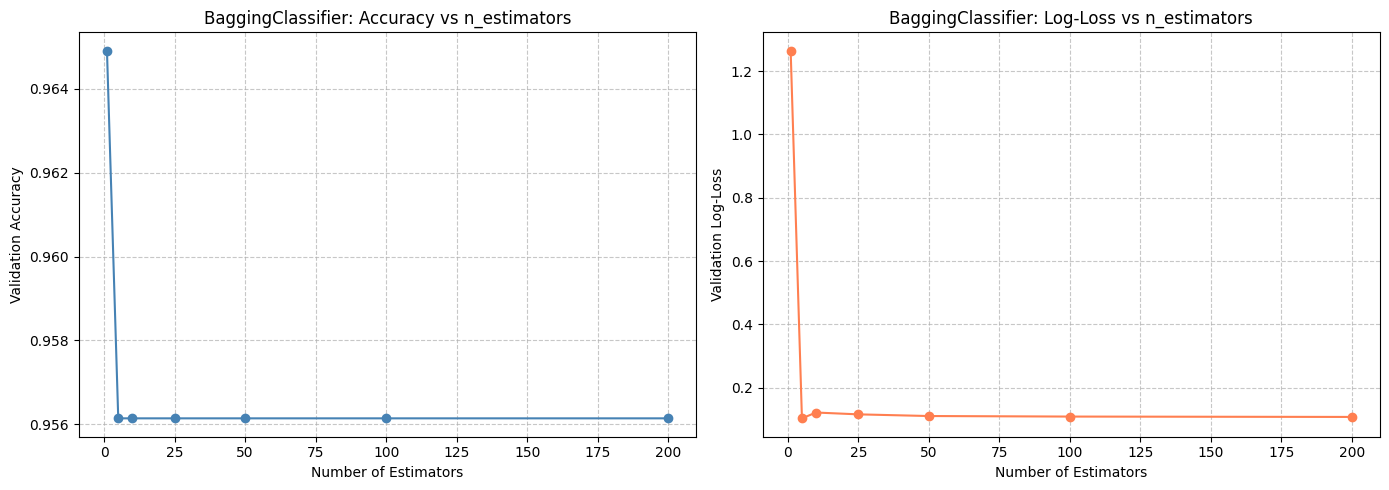

In [9]:
n_estimator_values = [1, 5, 10, 25, 50, 100, 200]
bagging_results = []

for n in n_estimator_values:
    bag = BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=n,
        random_state=random_seed
    )
    bag.fit(train_X, train_y)

    prob_val = bag.predict_proba(val_X)[:, 1]
    pred_val = bag.predict(val_X)

    bagging_results.append({
        'n_estimators': n,
        'accuracy': accuracy_score(val_y, pred_val),
        'log_loss': log_loss(val_y, prob_val)
    })

bag_df = pd.DataFrame(bagging_results)
print(bag_df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(bag_df['n_estimators'], bag_df['accuracy'], 'o-', color='steelblue')
axes[0].set_xlabel('Number of Estimators')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('BaggingClassifier: Accuracy vs n_estimators')
axes[0].grid(True, linestyle='--', alpha=0.7)

axes[1].plot(bag_df['n_estimators'], bag_df['log_loss'], 'o-', color='coral')
axes[1].set_xlabel('Number of Estimators')
axes[1].set_ylabel('Validation Log-Loss')
axes[1].set_title('BaggingClassifier: Log-Loss vs n_estimators')
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Diminishing returns set in around 50–100 trees. Adding more trees beyond this point gives only marginal improvement but costs more computation.

---
## Exercise 9 – Random Forest & hyperparameter tuning

1. Fit a default `RandomForestClassifier` and evaluate.
2. Use `GridSearchCV` to tune hyperparameters.
3. Plot feature importances.

Default RF — Accuracy: 0.9649
Default RF — Log-Loss: 0.0954
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best params: {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
Tuned RF — Accuracy: 0.9649
Tuned RF — Log-Loss: 0.0967


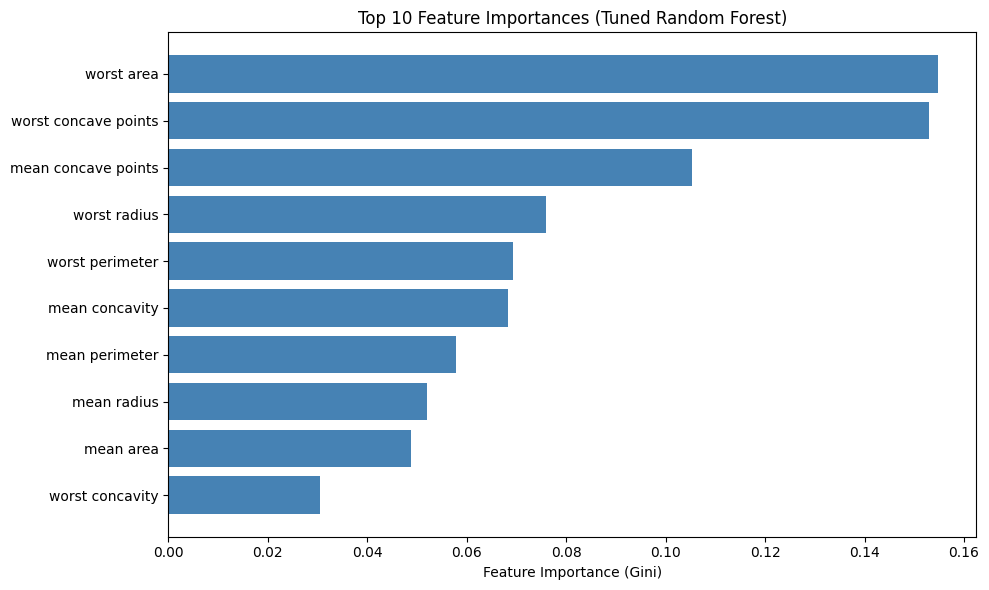

In [10]:
# Default Random Forest
rf = RandomForestClassifier(random_state=random_seed)
rf.fit(train_X, train_y)

pred_val_rf = rf.predict(val_X)
prob_val_rf = rf.predict_proba(val_X)[:, 1]

print(f"Default RF — Accuracy: {accuracy_score(val_y, pred_val_rf):.4f}")
print(f"Default RF — Log-Loss: {log_loss(val_y, prob_val_rf):.4f}")

# GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=random_seed),
    param_grid_rf,
    scoring='neg_log_loss',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_rf.fit(train_X, train_y)

print(f"\nBest params: {grid_rf.best_params_}")

best_rf = grid_rf.best_estimator_
pred_val_best = best_rf.predict(val_X)
prob_val_best = best_rf.predict_proba(val_X)[:, 1]

print(f"Tuned RF — Accuracy: {accuracy_score(val_y, pred_val_best):.4f}")
print(f"Tuned RF — Log-Loss: {log_loss(val_y, prob_val_best):.4f}")

# Feature importances
importances = best_rf.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': data.feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='steelblue')
plt.xlabel('Feature Importance (Gini)')
plt.title('Top 10 Feature Importances (Tuned Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
## Bonus – Model comparison

Create a summary comparing all models.

                                  Model  Val Accuracy  Val Log-Loss
                Single DT (max_depth=3)      0.947368      0.760441
               Single DT (best depth=2)      0.929825      0.228819
Manual ensemble (50 bootstrapped trees)      0.956140      0.107225
                BaggingClassifier (n=5)      0.956140      0.103040
                  Random Forest (tuned)      0.964912      0.096743


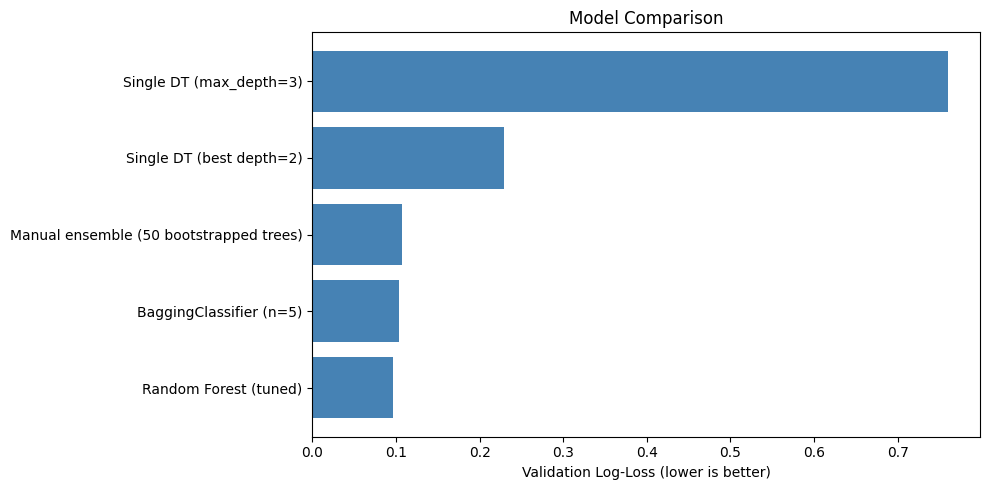

In [11]:
# Re-evaluate best single DT from GridSearchCV (exercise 4)
best_dt = DecisionTreeClassifier(max_depth=best_depth, random_state=random_seed)
best_dt.fit(train_X, train_y)
pred_best_dt = best_dt.predict(val_X)
prob_best_dt = best_dt.predict_proba(val_X)

# Best bagging result
best_bag_row = bag_df.loc[bag_df['log_loss'].idxmin()]

# Build comparison table
comparison = pd.DataFrame([
    {'Model': 'Single DT (max_depth=3)',
     'Val Accuracy': accuracy_score(val_y, cls.predict(val_X)),
     'Val Log-Loss': log_loss(val_y, cls.predict_proba(val_X))},
    {'Model': f'Single DT (best depth={best_depth})',
     'Val Accuracy': accuracy_score(val_y, pred_best_dt),
     'Val Log-Loss': log_loss(val_y, prob_best_dt)},
    {'Model': 'Manual ensemble (50 bootstrapped trees)',
     'Val Accuracy': accuracy_score(val_y, (mean_pred >= 0.5).astype(int)),
     'Val Log-Loss': log_loss(val_y, mean_pred)},
    {'Model': f'BaggingClassifier (n={int(best_bag_row["n_estimators"])})',
     'Val Accuracy': best_bag_row['accuracy'],
     'Val Log-Loss': best_bag_row['log_loss']},
    {'Model': 'Random Forest (tuned)',
     'Val Accuracy': accuracy_score(val_y, pred_val_best),
     'Val Log-Loss': log_loss(val_y, prob_val_best)}
])

print(comparison.to_string(index=False))

# Bar chart
plt.figure(figsize=(10, 5))
bars = plt.barh(comparison['Model'], comparison['Val Log-Loss'], color='steelblue')
plt.xlabel('Validation Log-Loss (lower is better)')
plt.title('Model Comparison')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Summary: Ensemble methods (bagging and random forest) consistently outperform single decision trees. The improvement comes from variance reduction — averaging many diverse trees produces more reliable predictions. The random forest adds further improvement by decorrelating trees via random feature subsets.

Compared to logistic regression from the 2.1 exercises, tree-based ensembles can capture non-linear decision boundaries and often achieve better or comparable performance without manual feature scaling.